# Optically-dark short GRBs

## Imports/loading/setup

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, importlib
from astropy.io import votable, ascii
alpha = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
numeric = ".0123456789"
calc_code = importlib.import_module("Calculation Code.main")
graph_code = importlib.import_module("Graphing Code.Graphing_Beta_OX")

class custom_iter: # custom iterator class that allows for retrieval of current element w/out advancing
    def __init__(self, iterable):
        self.iterator = iter(iterable)
        self.current = None
    def __next__(self):
        try:
            self.current = next(self.iterator)
        except StopIteration:
            self.current = None
        finally:
            return self.current

In [2]:
swift = pd.read_html("https://swift.gsfc.nasa.gov/archive/grb_table/fullview/")[0] # get latest Swift catalog
swift.columns = [col[0] for col in swift.columns] # reduce MultiIndex
sGRBs = swift[swift["BAT T90[sec]"].apply(pd.to_numeric, errors="coerce") <= 2] # filter catalog for GRBs with T90 under 2 sec

## Data parsing and cleanup

In [3]:
# format columns
sGRBs.drop(['Time[UT]', 'BAT RA(J2000)', 'BAT Dec(J2000)', 'BAT 90%Error Radius[arcmin]',
       'BAT Fluence(15-150 keV)[10-7 erg/cm2]', 'BAT Fluence90% Error(15-150 keV)[10-7 erg/cm2]',
       'BAT 1-sec PeakPhoton Flux(15-150 keV)[ph/cm2/sec]', 'BAT 1-sec PeakPhoton Flux90% Error(15-150 keV)[ph/cm2/sec]',
       'BAT Photon Index(15-150 keV)(PL = simple power-law,CPL = cutoff power-law)', 'BAT Photon Index90% Error(15-150 keV)',
       'XRT RA(J2000)', 'XRT Dec(J2000)', 'XRT 90%Error Radius[arcsec]', 'XRT Column Density(NH)[1021 cm-2]',
       'XRT Early Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'XRT 11 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]',
       'XRT 24 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'UVOT RA(J2000)', 'UVOT Dec(J2000)', 'UVOT 90%Error Radius[arcsec]',
       'Host Galaxy', 'Comments', 'References', 'Burst Advocate'],axis=1,inplace=True) # already in master catalog
sGRBs.rename(columns={'XRT Time to FirstObservation[sec]':'XRT dt [sec]',
                      'UVOT Time toFirst Observation[sec]':'UVOT dt [sec]',
                      'UVOT Other FilterMagnitudes':'Other UVOT Filters'},inplace=True)

mags = pd.Series([]) # numerical magnitudes
lims = pd.Series([]) # what kind of limit?
for idx,mag in sGRBs["UVOT Magnitude"].iteritems():
    #print(idx)
    try:
        mags[idx] = float(mag)
        lims[idx] = "equal"
    except ValueError:
        if ">" in mag:
            lims[idx] = "brightest"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in "0123456789."]))
        elif "=" in mag:
            lims[idx] = "equal"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in "0123456789."]))
        else:
            print(mag)
            lims[idx] = "equal"
            mags[idx] = np.nan

sGRBs["UVOT Vmag"] = mags
sGRBs["UVOT Vmag lim"] = lims

See GCN 10184


In [4]:
def split_filters(string):
    UVOT_filters = ["B","U","UVW1","UVM2","UVW2","White"]
    name_idxs = custom_iter([string.index(i) for i in UVOT_filters if i in string])
    split_list = [string[name_idxs.current:next(name_idxs)] for i in range(len(UVOT_filters))]
    split_list = [item for item in split_list if len(item)>0]
    return np.unique(split_list).tolist()

In [5]:
optical_obs = []
for idx,entry in sGRBs["Other UVOT Filters"].iteritems():
    if pd.isna(entry):
        entries = []
    else:
        entries = split_filters(entry)
    try:
        filterdict = dict([entry.split(">") if ">" in entry else entry.split("=") if "=" in entry else None for entry in entries])
        filterdict["idx"] = idx
        optical_obs.append(filterdict)
    except:
        print("error",idx,end="; ")

for obs in optical_obs:
    sGRBs["Other UVOT Filters"][obs["idx"]] = obs

error 179; error 307; error 486; error 527; error 575; error 604; error 686; error 819; error 1014; error 1029; error 1095; error 1248;

In [6]:
sGRBs["Redshift"] = ["".join([char for char in entry if char in numeric]) if type(entry) is str else entry for entry in sGRBs["Redshift"]]

In [7]:
sGRBs.to_csv("./Required Files/Files for Loading/Swift_sGRB_catalog.csv",index=False)
sGRBs.head()

,GRB,Time[UT],TriggerNumber,BAT T90[sec],XRT dt [sec],XRT InitialTemporalIndex,XRTSpectral Index(Gamma),UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim
19,200522A,11:41:34,973628,0.62,83.42,-0.6754,1.38048,448,V>17.2,"{'White': '19.5', 'idx': 19}","VLA @ 6 GHZ (possibly from host), LCO (1m), Ge...",0.4,17.2,brightest
28,200411A,04:29:02,965784,0.22,50.74,-0.9587,1.76864,58,V>18.5,"{'B': '20.3', 'U': '21.0', 'UVM2': '18.1', 'UV...",Fermi (GBM),NaN,18.5,brightest
66,191031D,21:23:31,932608,0.29,88.83,-1.982,1.88342,93,V>19.9,"{'B': '20.4', 'U': '20.3', 'UVM2': '19.6', 'UV...","Fermi (GBM), AGILE (MCAL), Konus-Wind, AstroSa...",NaN,19.9,brightest
96,190627A,11:18:31,911609,1.60,109.76,-0.3297,1.95997,115,NaN,"{'White': '18.15', 'idx': 96}","NUTTelA-TAO, Montarrenti Observatory (0.53m), ...",1.942,NaN,equal
100,190610A,11:27:45,907754,0.62,292300,NaN,NaN,292282,V>20.3,{'idx': 100},"Insight-HXMT/HE, CALET, Konus-Wind",NaN,20.3,brightest


## Old data handling

In [8]:
BetaXData = pd.read_csv("./Required Files/Files for Loading/BetaXData.csv", header=None)
OpticalData = pd.read_csv("./Required Files/Files for Loading/OpticalData.csv", header=None)
XRayData = pd.read_csv("./Required Files/Files for Loading/XRayData.csv", header=None)

In [9]:
old_ids = np.unique([entry.split("-")[1] for entry in XRayData.iloc[:,0]]+[entry.split("-")[1] for entry in OpticalData.iloc[:,0]]+[entry.split("-")[1] for entry in BetaXData.iloc[:,0]])

print(old_ids) # all the GRB IDs that David already looked at in his work

#new_sGRBs = sGRBs[~sGRBs["GRB"].isin(old_ids)] # filter such that we're only working with GRBs that David ~didn't~ already look at
new_sGRBs = sGRBs[[int(grb[:6]) > 150301 for grb in sGRBs["GRB"]]] # Fong et al. 2015 has data through March 2015, i.e. 150301A

['050202' '050509B' '050709' '050724A' '050813' '050906' '050925' '051210'
 '051221A' '060121' '060313' '060502B' '060801' '061006' '061201' '061210'
 '061217' '070209' '070406' '070429B' '070707' '070714B' '070724A'
 '070729' '070809' '070810B' '071017' '071112B' '071227' '080121' '080123'
 '080426' '080503' '080702A' '080905A' '080919' '081024A' '081024B'
 '081226A' '081226B' '090305' '090305A' '090426' '090426A' '090510'
 '090515' '090607' '090621B' '090916' '091109B' '091117' '100117A'
 '100206A' '100213' '100625A' '100628A' '100702A' '101219A' '101224A'
 '110112A' '110112B' '110420B' '111020A' '111117A' '111121A' '111222A'
 '120229A' '120305A' '120521A' '120630A' '120804A' '120817B' '121226A'
 '130313A' '130515A' '130603B' '130626A' '130716A' '130822A' '130912A'
 '131004A' '131125A' '131126A' '131224A' '140129B' '140320A' '140402A'
 '140414A' '140516A' '140606A' '140619B' '140622A' '140903A' '140930B'
 '141202A' '141205A' '141212A' '150101A' '150101B' '150120A' '150301A']


In [10]:
new_sGRBs

,GRB,Time[UT],TriggerNumber,BAT T90[sec],XRT dt [sec],XRT InitialTemporalIndex,XRTSpectral Index(Gamma),UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim
19,200522A,11:41:34,973628,0.62,83.42,-0.6754,1.38048,448,V>17.2,"{'White': '19.5', 'idx': 19}","VLA @ 6 GHZ (possibly from host), LCO (1m), Ge...",0.4,17.20,brightest
28,200411A,04:29:02,965784,0.22,50.74,-0.9587,1.76864,58,V>18.5,"{'B': '20.3', 'U': '21.0', 'UVM2': '18.1', 'UV...",Fermi (GBM),NaN,18.50,brightest
66,191031D,21:23:31,932608,0.29,88.83,-1.982,1.88342,93,V>19.9,"{'B': '20.4', 'U': '20.3', 'UVM2': '19.6', 'UV...","Fermi (GBM), AGILE (MCAL), Konus-Wind, AstroSa...",NaN,19.90,brightest
96,190627A,11:18:31,911609,1.60,109.76,-0.3297,1.95997,115,NaN,"{'White': '18.15', 'idx': 96}","NUTTelA-TAO, Montarrenti Observatory (0.53m), ...",1.942,NaN,equal
100,190610A,11:27:45,907754,0.62,292300,NaN,NaN,292282,V>20.3,{'idx': 100},"Insight-HXMT/HE, CALET, Konus-Wind",NaN,20.30,brightest
108,190427A,04:34:15,900730,0.3,3735.8,NaN,NaN,3737,NaN,"{'U': '19.9', 'idx': 108}","Fermi (GBM), CALET (CGBM)",NaN,NaN,equal
114,190326A,07:35:28,895006,0.08,NaN,NaN,NaN,NaN,NaN,"{'UVW1': '20.47', 'idx': 114}",Insight-HXMT/HE,NaN,NaN,equal
143,181123B,05:33:03,873186,0.26,80.25,-1.404,1.98751,84,V>19.8,"{'B': '20.1', 'U': '20.1', 'UVM2': '20.5', 'UV...",Insight-HXMT/HE,NaN,19.80,brightest
172,180805A,09:04:49,851829,1.68,86.13,-0.3151,1.50420,89,V>18.0,"{'B': '19.1', 'U': '19.6', 'UVM2': '19.4', 'UV...",NaN,NaN,18.00,brightest
174,180727A,14:15:28,850231,1.1,NaN,-2.353,1.85342,77,V>19.6,"{'B': '21.2', 'U': '20.3', 'UVM2': '21.0', 'UV...",Fermi (GBM),NaN,19.60,brightest


In [11]:
burst = "200411A"
trigger = new_sGRBs.loc[sGRBs["GRB"] == burst, "TriggerNumber"]
lightcurveURL = f"https://www.swift.ac.uk/xrt_curves/{int(trigger):0>8}/flux.qdp"

In [12]:
fluxdata = pd.read_table(lightcurveURL, header=11).apply(pd.to_numeric, errors="coerce").dropna().reset_index(drop=True)
fluxdata.columns = ["Time","Tpos","Tneg","Flux","Fluxpos","Fluxneg"]

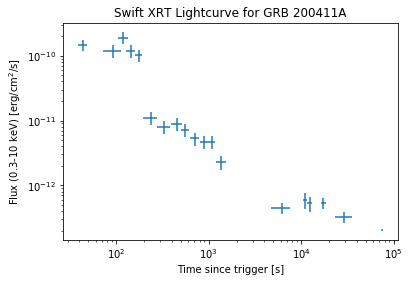

In [13]:
plt.errorbar(fluxdata.Time,fluxdata.Flux,xerr=np.array(fluxdata.Tneg,fluxdata.Tpos).T,yerr=np.array(fluxdata.Fluxneg,fluxdata.Fluxpos).T,linestyle="",capthick=0)
plt.xscale("log")
plt.yscale("log")
plt.title(f"Swift XRT Lightcurve for GRB {burst}")
plt.xlabel("Time since trigger [s]")
plt.ylabel("Flux (0.3-10 keV) [erg/cm$^2$/s]")
plt.show()